In [116]:
%run imports/VacuumGauge_functions.ipynb
%run imports/rbflayer.py

import pandas as pd
import numpy as np
import joblib
import tensorflow as tf
from tensorflow import keras

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

from sklearn.pipeline import Pipeline

## Reading the dataset

- df_ok: labels of ok gauges
- df_delta: labels of delta gauges
- df_ raw: raw data cointaining the full reading of each gauge

In [5]:
df_delta = pd.read_csv('data/datasets/df_delta.csv') # cointains labels for delta VG
df_ok = pd.read_csv('data/datasets/df_ok.csv')  #contains labels for ok VG

df_raw = pd.read_csv('data/datasets/df_raw.csv') ## contains full reading of each VG

df_labels = pd.concat([df_ok, df_delta], sort=False, axis=0)


df_VG = pd.merge(df_raw, df_labels, on =['gauge_id','fillNumber'])
df_VG = df_VG.set_index(['gauge_id','fillNumber'], drop=True)

## Removing categorical values
df_VG.y.replace(to_replace=['ok', 'delta'], value=[0, 1], inplace=True)

## Splitting the dataset in input and target
- X are the input features
- y is the target vector

Definition of a StratifiedKFold split to be used in all the grid searchs for all the model: 

In [6]:
X = np.array(df_VG.iloc[:, :-1])
y = np.array(df_VG.iloc[:, -1])

from sklearn.model_selection import StratifiedKFold

strat_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

## Hold out a test set for final evaluation

In [7]:
# from sklearn.model_selection import StratifiedShuffleSplit


# sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# print(sss)

# for train_index, test_index in sss.split(X, y):
#     print("TRAIN size:", len(train_index), "TEST size:", len(test_index))
#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = y[train_index], y[test_index]


# print(len(y_train))
# print(sum(y_train))
# print(len(y_test))
# print(sum(y_test))

## Quick overview on the PCA impact

PCA performed on the trainig part of the normalised dataset to visualize its impact.

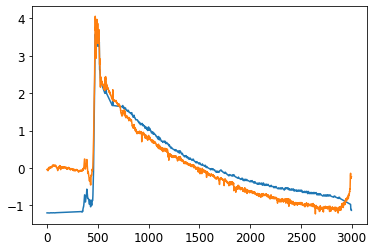

In [11]:
scaler = RowScaler('Standard')
# X_norm = scaler.fit_transform(X)
# X_norm[0].shape

i=100
X_m = scaler.fit_transform(X) - scaler.fit_transform(X).mean(axis=0, keepdims=0)
plt.figure()
plt.plot(range(3000), scaler.fit_transform(X)[i])
plt.plot(range(3000), X_m[i])
plt.show()

In [12]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)

X_pca = pca.fit_transform(scaler.fit_transform(X))
X_pca[1]

array([-18.09394979, -23.95543694,   0.97484352])

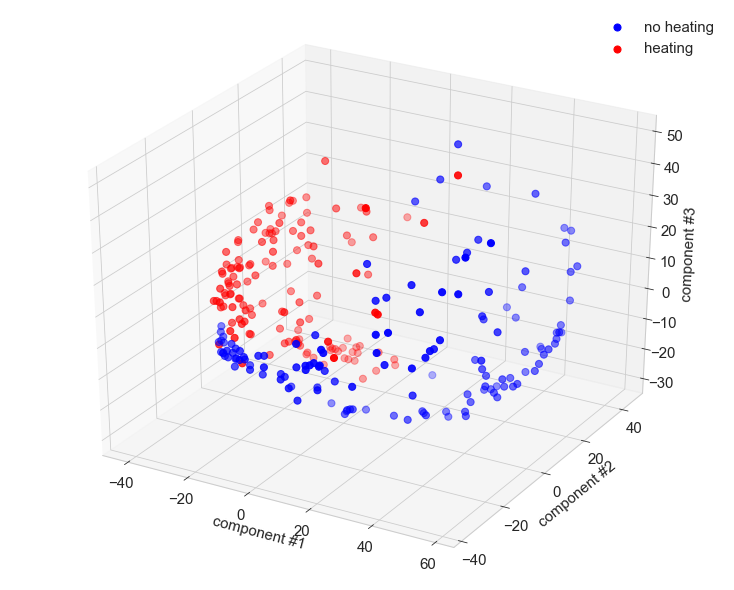

In [13]:
from mpl_toolkits.mplot3d import Axes3D
fontsize=15

ok = X_pca[y==0]
delta = X_pca[y ==1]

plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(10,8))
ax = Axes3D(fig)

ax.scatter(ok[:,0], ok[:,1], ok[:,2], c='b', label='no heating', s=50)
ax.scatter(delta[:,0], delta[:,1], delta[:,2], c='r', label='heating', s=50)

ax.set_xlabel('component #1', fontsize=fontsize)
ax.set_ylabel('component #2', fontsize=fontsize)
ax.set_zlabel('component #3', fontsize=fontsize)

# ax.set_xlim(-25,30)
# ax.set_ylim(-5,20)
# ax.set_zlim(-10,7.5)
plt.gca().patch.set_facecolor('white')
plt.tick_params(axis='both', which='major', labelsize=fontsize)
plt.legend(fontsize=fontsize)
plt.show()


## Random Forest

In [14]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = Pipeline([
    ('scaler', RowScaler(scaling_method='Standard')),
    ('pca', PCA(n_components=3)),
    ('forest', RandomForestClassifier())

])

model = forest_clf
model_dir = 'data/models/random_forest'
model_version = 'forest_001.pkl'
scoring = ['recall', 'accuracy', 'precision']

forest_path = os.path.join(model_dir, model_version)

print(os.path.join(model_dir,model_version))

data/models/random_forest/forest_001.pkl


#### GridSearch

In [15]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'scaler__scaling_method': RowScaler().scaling_options,
     'pca__n_components': range(2,6),
     'forest__n_estimators': range(100,200,20),
     'forest__max_leaf_nodes': range(3,8),
     'forest__bootstrap': [False],
    }
]


In [16]:
print("# Tuning hyper-parameters for {} and {}".format(scoring[0], scoring[1]))
print()
grid_search = GridSearchCV(
    estimator=model, 
    param_grid=param_grid, 
    scoring=scoring,
    n_jobs=-1,
    verbose=1, 
    cv=strat_kfold, 
    return_train_score=True,
    refit=scoring[0]  ## Score used for final refit
)

grid_search.fit(X, y)

# Tuning hyper-parameters for recall and accuracy

Fitting 5 folds for each of 400 candidates, totalling 2000 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   51.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:  8.8min finished
/Users/Francesco/anaconda3/envs/my_env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        RowScaler(scaling_method='Standard')),
                                       ('pca',
                                        PCA(copy=True, iterated_power='auto',
                                            n_components=3, random_state=None,
                                            svd_solver='auto', tol=0.0,
                                            whiten=False)),
                                       ('forest',
                                        RandomForestClassifier(bootstrap...
             iid='warn', n_jobs=-1,
             param_grid=[{'forest__bootstrap': [False],
                          'forest__max_leaf_nodes': range(3, 8),
                          'forest__n_estimators': range(100, 200, 20),
              

In [19]:
printGridSearchResults(grid_search, scoring[0])

Best parameters set found on development set:
{'forest__bootstrap': False, 'forest__max_leaf_nodes': 7, 'forest__n_estimators': 100, 'pca__n_components': 5, 'scaler__scaling_method': 'Robust'}

Grid scores on development set:

0.878 (+/-0.098) for {'forest__bootstrap': False, 'forest__max_leaf_nodes': 3, 'forest__n_estimators': 100, 'pca__n_components': 2, 'scaler__scaling_method': 'Standard'}
0.863 (+/-0.115) for {'forest__bootstrap': False, 'forest__max_leaf_nodes': 3, 'forest__n_estimators': 100, 'pca__n_components': 2, 'scaler__scaling_method': 'MinMax'}
0.827 (+/-0.171) for {'forest__bootstrap': False, 'forest__max_leaf_nodes': 3, 'forest__n_estimators': 100, 'pca__n_components': 2, 'scaler__scaling_method': 'MaxAbs'}
0.928 (+/-0.078) for {'forest__bootstrap': False, 'forest__max_leaf_nodes': 3, 'forest__n_estimators': 100, 'pca__n_components': 2, 'scaler__scaling_method': 'Robust'}
0.878 (+/-0.098) for {'forest__bootstrap': False, 'forest__max_leaf_nodes': 3, 'forest__n_estimator

In [17]:
grid_search.best_score_

0.9424460431654677

### Saving the model

In [18]:
save_model(grid_search, model_dir, model_version)

data/models/random_forest/forest_001.pkl succesfully saved.


## Logistic Regressor (classifier)

In [ ]:
from sklearn.linear_model import LogisticRegression

log_clf = Pipeline([
    ('scaler', RowScaler(scaling_method='Standard')),
    ('pca', PCA(n_components=3)),
    ('logistic', LogisticRegression())

])

model = log_clf
model_dir = 'data/models/logistic_classifier'
model_version = 'logistic_001.pkl'
scoring = ['recall', 'accuracy', 'precision']

log_path = os.path.join(model_dir, model_version)

print(os.path.join(model_dir, model_version))

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'scaler__scaling_method': RowScaler().scaling_options,
     'pca__n_components': range(2,6),
    }
]

In [ ]:
print("# Tuning hyper-parameters for {} and {}".format(scoring[0], scoring[1]))
print()
grid_search = GridSearchCV(
    estimator=model, 
    param_grid=param_grid, 
    scoring=scoring,
    n_jobs=-1,
    verbose=1, 
    cv=strat_kfold, 
    return_train_score=True,
    refit=scoring[0]  ## Score used for final refit
)

grid_search.fit(X_train, y_train)

In [ ]:
printGridSearchResults(grid_search, scoring[0])

In [ ]:
grid_search.best_score_

### Saving the model

In [ ]:
#print(grid_search)
save_model(grid_search, model_dir, model_version)

## KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = Pipeline([
    ('scaler', RowScaler(scaling_method='Standard')),
    ('pca', PCA()),
    ('knn', KNeighborsClassifier())

])

model = knn_clf
model_dir = 'data/models/knn'
model_version = 'knn_001.pkl'
scoring = ['recall', 'accuracy', 'precision']

knn_path = os.path.join(model_dir, model_version)
print(os.path.join(model_dir, model_version))

In [ ]:
param_grid = [
    {'scaler__scaling_method': RowScaler().scaling_options,
     'pca__n_components': range(2,6),
     'knn__n_neighbors': range(3,7),
     'knn__n_jobs': [-1]
    }
]

In [ ]:
print("# Tuning hyper-parameters for {} and {}".format(scoring[0], scoring[1]))
print()
grid_search = GridSearchCV(
    estimator=model, 
    param_grid=param_grid, 
    scoring=scoring,
    n_jobs=-1,
    verbose=1, 
    cv=strat_kfold, 
    return_train_score=True,
    refit=scoring[0]  ## Score used for final refit
)

grid_search.fit(X_train, y_train)

In [ ]:
printGridSearchResults(grid_search, scoring[0])

In [ ]:
grid_search.best_score_

In [ ]:
save_model(grid_search, model_dir, model_version)

## CNN 

In [6]:
print(X_train.shape)

(222, 3000)


Function that builds the CNN for the gridsearch. Each layer is a Con1d and a maxpool. Each layer reduce the second axis dimension of a factor 2.

In [28]:
keras.backend.clear_session()


def build_CNN(filters=15, kernel_size=20, learning_rate=0.001, layers=1):
    model = keras.models.Sequential()
    model.add(keras.layers.Lambda(lambda X: rowScale(X), input_shape=[3000]))
    model.add(keras.layers.Reshape((3000, 1)))

    for l in range(layers):
        model.add(keras.layers.Conv1D(filters=filters, kernel_size=kernel_size,
                    activation='relu', padding='same', use_bias=True))
        model.add(keras.layers.MaxPool1D(pool_size=2, padding='valid'))

    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(units=100, activation='relu'))
    model.add(keras.layers.Dense(units=1, activation='sigmoid'))

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=[keras.metrics.Recall()])
    return model
class_weight = {0: 1.,
                1: 50.}
model = build_CNN(layers=1)
model.summary()
# history = model.fit(X_train, y_train, epochs=5, class_weight=class_weight, verbose=1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 3000)              0         
_________________________________________________________________
reshape (Reshape)            (None, 3000, 1)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 3000, 15)          315       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1500, 15)          0         
_________________________________________________________________
flatten (Flatten)            (None, 22500)             0         
_________________________________________________________________
dense (Dense)                (None, 100)               2250100   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
y_pred = model.predict(X_test)
y_pred = np.round(y_pred)
print(accuracy_score(y_test, y_pred))
print(recall_score(y_test, y_pred))
print(precision_score(y_test, y_pred))

In [ ]:
cnn_clf = keras.wrappers.scikit_learn.KerasClassifier(build_CNN)

model = cnn_clf
model_dir = 'data/models/cnn'
model_version = 'cnn_001.pkl'
scoring = ['recall', 'accuracy', 'precision']


In [ ]:
param_grid = [
    {'layers': [1,2,3],
    }
]

In [ ]:
keras.backend.clear_session()

print("# Tuning hyper-parameters for {} and {}".format(scoring[0], scoring[1]))
print()
grid_search = GridSearchCV(
    estimator=model, 
    param_grid=param_grid, 
    scoring=scoring,
    n_jobs=-1,
    verbose=1, 
    cv=strat_kfold, 
    return_train_score=True,
    refit=scoring[0]  ## Score used for final refit
)

grid_search.fit(X_train, y_train, epochs=20)

In [ ]:
printGridSearchResults(grid_search, scoring[0])

In [ ]:
a = np.array(range(30)).reshape(6,5)
print(a)
print(a.T)
print((a- np.mean(a, axis=1).reshape(-1,1))/np.std(a, axis=1).reshape(-1,1))
np.mean(a, axis=1).T

In [ ]:
layer = keras.layers.Lambda(lambda X: (X - tf.reshape(tf.reduce_mean(X, axis=1), [-1, 1]))/tf.reshape(tf.math.reduce_std(X, axis=1), [-1,1]), dtype=tf.float32)
output = layer(X_train)
print(output)

In [ ]:
scaler = RowScaler(scaling_method='Standard')
i = 0
plt.plot(range(3000), output[i])
plt.show()

plt.plot(range(3000), scaler.fit_transform(X_train)[i])
plt.show()

plt.plot(range(3000), ((X_train[i] - np.mean(X_train[i]))/np.std(X_train[i])))
plt.show()

In [ ]:
mean, var = tf.nn.moments(tf.constant(a), axes=[1])
print(tf.reshape(mean, [-1,1]))
print(var)

In [ ]:
# y_pred = grid_search.best_estimator_.predict(X_test)

# from sklearn.metrics import recall_score, precision_score, accuracy_score

# recall_score(y_test, y_pred)

## RBF

In [22]:
df_raw = df_raw[df_raw.fillNumber != 2011]

df_raw = df_raw.astype({'fillNumber': 'int'})
df_raw = df_raw.set_index(['gauge_id','fillNumber'], drop=True)
df_raw.index.get_level_values('fillNumber').value_counts()

5979    808
5980    806
2010    676
2025    673
2009    673
2022    672
2216    672
2040    670
Name: fillNumber, dtype: int64

In [23]:
from sklearn.cluster import KMeans


scaler = RowScaler(scaling_method='Standard')

In [52]:
X_scaled = scaler.fit_transform(df_raw)

kmeans_per_k = [KMeans(n_clusters=k,
                                  algorithm='elkan',
                                  random_state=42,
                                  n_jobs=-1,
                                  verbose=2
                                  ).fit(X_scaled)
                for k in range(2, 20)]

inertias = [model.inertia_ for model in kmeans_per_k]

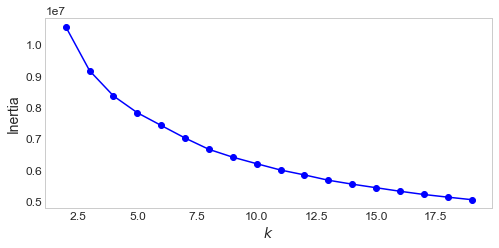

In [53]:
plt.figure(figsize=(8, 3.5))
plt.plot(range(2, 20), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.grid(False)
plt.show()

In [33]:
from sklearn.metrics import silhouette_score
# silhouette_score(X_scaled, kmeans_per_k[1].labels_)

array([0, 6, 9, 9, 6, 9, 9, 9, 7, 9, 5, 5, 1, 5, 1, 1, 1, 1, 8, 1],
      dtype=int32)

In [75]:
silhouette_scores = [silhouette_score(X_scaled, model.labels_)
                     for model in kmeans_per_k]

inertias = np.array(inertias)
np.save('intertias_range_2_20.npy', inertias)

silhouette_scores = np.array(silhouette_scores)
np.save('data/datasets/silhouette_scores_range_2_20.npy', silhouette_scores)

k12_centers = np.array(kmeans_per_k[12 -2].cluster_centers_)
np.save('data/datasets/k12_centers.npy', k12_centers)

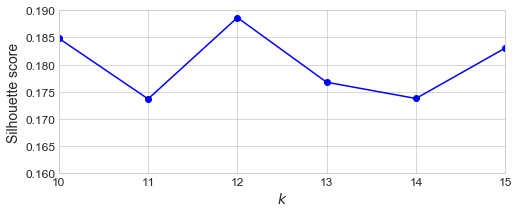

In [69]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 20), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.xlim(10,15)
plt.ylim(0.16, 0.19)
plt.ylabel("Silhouette score", fontsize=14)
plt.show()

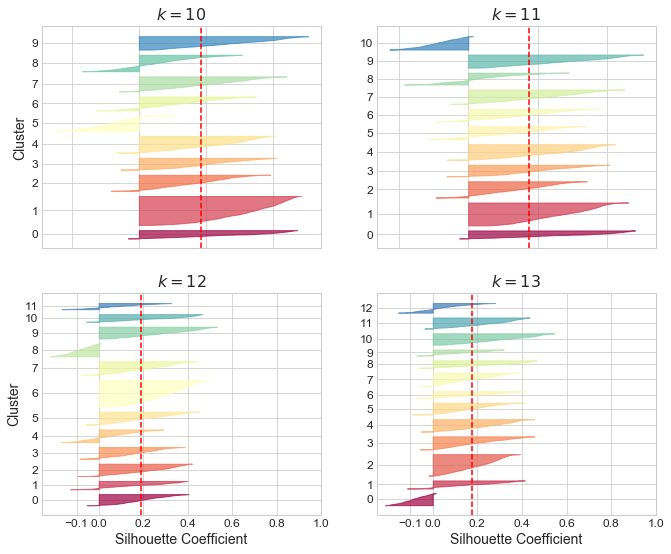

In [74]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(11, 9))

for k in (10, 11, 12, 13):
    plt.subplot(2, 2, k - 9)
    
    y_pred = kmeans_per_k[k - 2].labels_
    silhouette_coefficients = silhouette_samples(X_scaled, y_pred)

    padding = len(X_scaled) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (10, 12):
        plt.ylabel("Cluster")
    
    if k in (12, 13):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)


plt.show()

In [81]:
len(kmeans_per_k[12 -2].cluster_centers_)
k12_centers.shape

(12, 3000)

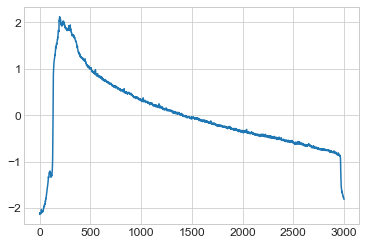

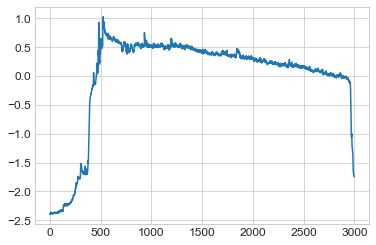

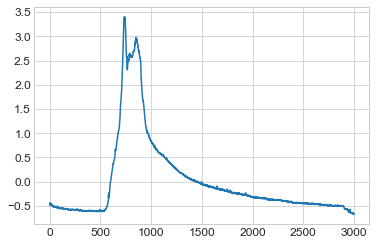

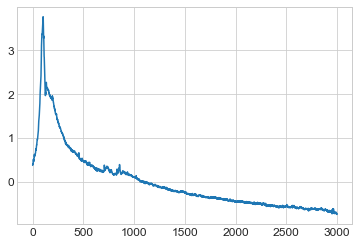

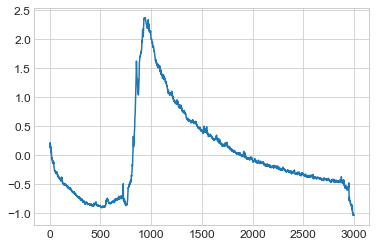

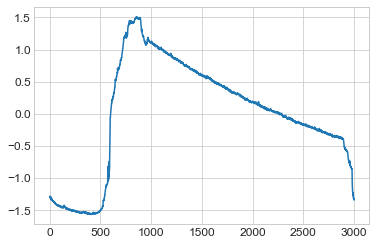

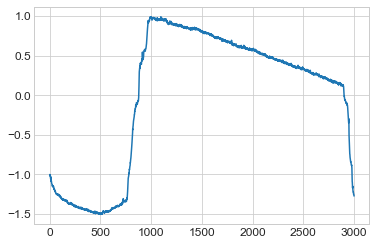

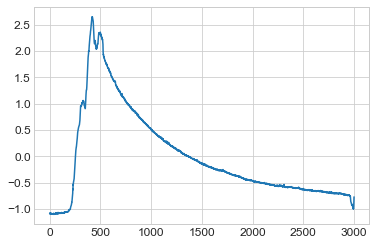

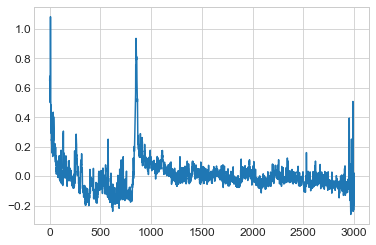

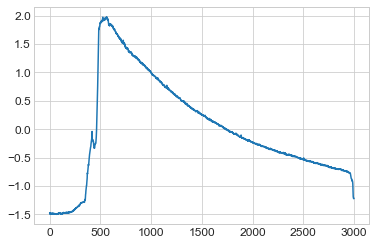

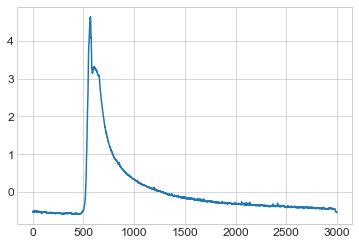

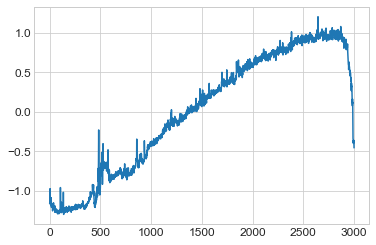

In [108]:
k12_centers = np.load('data/datasets/k12_centers.npy')
for c in k12_centers:
    plt.plot(range(3000), c)
    plt.show()

In [119]:
d_max = np.max(euclidean_distances(k12_centers, k12_centers))
keras.backend.clear_session()
model = keras.models.Sequential()
model.add(keras.layers.Lambda(lambda X: rowScale(X), input_shape=[3000]))
model.add(RBFLayer(12,
                    initializer=InitFromFile('data/datasets/k12_centers.npy'),
                    betas=d_max/np.sqrt(len(k12_centers)),
                    trainable=False,
                    input_shape=[3000])
                    )
model.add(keras.layers.Dense(1, activation='sigmoid'))

optimizer = keras.optimizers.Adam()

model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=[keras.metrics.Recall()])

model.summary()
model.get_weights()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 3000)              0         
_________________________________________________________________
rbf_layer (RBFLayer)         (None, 12)                36012     
_________________________________________________________________
dense (Dense)                (None, 1)                 13        
Total params: 36,025
Trainable params: 13
Non-trainable params: 36,012
_________________________________________________________________


[array([[-2.1164005 , -2.119006  , -2.1362445 , ..., -1.7929586 ,
         -1.8011711 , -1.8127755 ],
        [-2.3814256 , -2.3917806 , -2.3915775 , ..., -1.7250103 ,
         -1.7411628 , -1.7454612 ],
        [-0.45441002, -0.4406159 , -0.46756515, ..., -0.6748551 ,
         -0.6775143 , -0.67403114],
        ...,
        [-1.4720175 , -1.4963709 , -1.4938457 , ..., -1.2250153 ,
         -1.2230327 , -1.2192667 ],
        [-0.52028614, -0.5281814 , -0.5321289 , ..., -0.5307569 ,
         -0.54318655, -0.542097  ],
        [-1.1610963 , -1.1430545 , -1.1023331 , ..., -0.3745212 ,
         -0.36989984, -0.45521298]], dtype=float32),
 array([23.415413, 23.415413, 23.415413, 23.415413, 23.415413, 23.415413,
        23.415413, 23.415413, 23.415413, 23.415413, 23.415413, 23.415413],
       dtype=float32),
 array([[ 0.2552939 ],
        [-0.02108914],
        [ 0.5856061 ],
        [-0.33671156],
        [ 0.31407642],
        [ 0.5333952 ],
        [ 0.6070113 ],
        [ 0.33877838],
  

In [120]:
history = model.fit(X, y, epochs=5, validation_split=0.33, verbose=1)

Epoch 1/5
6/6 [==============================] - 0s 65ms/step - loss: 0.6931 - recall: 0.8125 - val_loss: 0.6933 - val_recall: 1.0000
Epoch 2/5
6/6 [==============================] - 0s 29ms/step - loss: 0.6931 - recall: 1.0000 - val_loss: 0.6934 - val_recall: 1.0000
Epoch 3/5
6/6 [==============================] - 0s 26ms/step - loss: 0.6930 - recall: 1.0000 - val_loss: 0.6934 - val_recall: 1.0000
Epoch 4/5
6/6 [==============================] - 0s 27ms/step - loss: 0.6931 - recall: 1.0000 - val_loss: 0.6935 - val_recall: 1.0000
Epoch 5/5
6/6 [==============================] - 0s 23ms/step - loss: 0.6930 - recall: 1.0000 - val_loss: 0.6935 - val_recall: 1.0000


In [110]:
from sklearn.metrics.pairwise import euclidean_distances

a = range(12)
b = range(4, 5, 1)
a = np.array(a).reshape(3, 4)
print(a)
d_max = np.max(euclidean_distances(k12_centers, k12_centers))
d_ave = np.mean(euclidean_distances(k12_centers, k12_centers))
print(d_max/np.sqrt(12))
print(d_max/np.sqrt(len(k12_centers)))

[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]]
23.415413275077757
23.415413275077757


domande:
devo abilitare il training sul layer RBF? iniziamo senza farlo
definire modelli finali: pca solo su training, kmeans su tutto unlabelled
train - val- test split, va bene? No usiamo solo k fold
quante fold nel k fold? meglio 10
perche RNN cosi lenta?